This notebook is part of a series in which we will explore different state-of-the-art techniques that have been recently developed and are used for building LLM applications. We go over high-level concepts used in fine-tuning an LLM model, and build a pipeline to fine-tune Google's Gemma 2 model.

## 1. Introduction 
Large Language Models (LLM), in essence are very huge neural networks containing billions of parameters. In recent years, LLMs have have demonstrated remarkable success in a lot of tasks like text generation, chat bots, code generation etc. A lot of new techniques have been developed for training these models and adapting them for specific applications. In this notebook we aim to cover one of these techniques, viz. Fine Tuning LLM. This guide focuses on the fine-tuning process of a Large Language Model for English-to-Hindi translation tasks. a Large Language Model for English to Hindi translation task. In this notebook we fine-tune Gemma 2b, a two-billion parameter small-LLM developed by Google. We utilize a Hindi-English translation dataset to improve performance of Gemma 2-2b model on Hindi to English machine translation task. We make use of open-source dataset curated by Computation for Indian Language Technology (CFILT), IIT Bombay. This dataset is a collection of around 1,659,083 English sentences and their Hindi translations. We cover the details of this dataset in a later section.

Gemma 2 is a family of lightweight open-source LLM released by Google in 2024. They are  decoder-only large language models, available in English. Gemma models are well-suited for a variety of text-generation tasks, including question-answering, summarization, and reasoning. Gemma 2 has models in sizes: 2 billion, 9 billion and 27 billion parameters.

### Motivation for Hindi-English Translation
Hindi is one of the low-resource language with limited support across LLM models. The complexities of grammatical structures, vocabulary differences, cultural contexts, script variations, and syntactic intricacies make English to Hindi translation a challenging yet fascinating task. Our goal is to see how well Gemma performs on this task, and how much can we improve its performance by fine-tuning it with a small dataset.


### Why Fine-Tune an LLM?
LLMs are trained using a large corpus of datasets. They are able to answer general questions about a variety of topics. More often we are interested in utilizing LLMs for specific tasks like question-answering, information retrieval from organization's documents, building chatbots for customer service, machine translation of text from one language to another, etc. among others. These applications require us to update the knowledge of LLMs using relevant datasets. Two prominent methods used to improve an existing pre-trained model for specific tasks are fine-tuning and retrieval augmented generation (RAG). A RAG pipeline augments LLM by using a retrieved-context (relevant text) from an existing database/datasource. We store relevant documents in a database (usually a vector database), and query this database to get this relevant text based on how similar it is to our prompt. Then retrieved-context is added to the original prompt and passed to LLM, this provides additional information to LLM to generate its response. 
    
Fine-tuning involves adapting a pre-trained model to a specific task. It helps improve LLM's capabilities on domain-specific datasets that were not used in training the model. In this, we update parameters (also called weights) from a few or all layers of the neural network model (LLM). This is done by using a labeled dataset related to a specific task to train the model to update its parameters. This enables the fine-tuned model to have better performance for the specific task. 

LLMs have a lot of parameters (weights). Fine-tuning an LLM model and updating of all of its parameters can be a tedious task requiring a lot of time and computation resources. The Gemma 2 2B that is being used in this notebook has 2,617,270,528 parameters! Updating all parameters will be a resource-heavy process that will take up a lot of time. To get around the time and compute resource limitation, we make use of a new method called Low-Rank Adaptation (LoRA). This technique, in summary, helps lower the number of trained weights needed by a lot, making fine-tuning more accessible on smaller machines. 

Once we have fine-tuned the model, for evaluation, we compare the performance of baseline Gemma 2b model with the fine-tuned model using BLEU score, a commonly used metrics for machine translation task, to see how much does the model improve with our fine tuning. Manual evaluations by Human evaluators is more rigorous for machine translation tasks, but it is expensive. So in this exercise we rely on offline metrics like BLEU score. The evaluation code and results are available in the notebook named Gemma-English-Hindi Evaluation.



In [1]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

import os
import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TrainingArguments, pipeline
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

import warnings
import time

warnings.filterwarnings('ignore')
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Configs 
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

model_id = "gemma2_instruct_2b_en"
token_limit = 256

# Run at half precision.
#keras.config.set_floatx("bfloat16")


In [3]:
def calculate_bleu_score(reference, candidate):
    reference_tokens = word_tokenize(reference)
    candidate_tokens = word_tokenize(candidate)

    return sentence_bleu([reference_tokens], candidate_tokens)

def clean_model_output(txt):
    """Removes the control tokens from model output """
    txt = txt[txt.find('model') + 6 : -14]
    return txt

In [4]:
# Helpers : https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/Advanced_Prompting_Techniques.ipynb
def convert_message_to_prompt(message: str, model_prefix: str = "") -> str:
    """Converts a message to a prompt for a large language model.

    Args:
        message: The message to convert (str).
        model_prefix: An optional prefix to prepend to the model response (str).

    Returns:
        A string containing the prompt for the large language model (str).
    """

    return (
        f"<start_of_turn>user\n Translate the sentence into hindi and only return the translation. Text :  {message}<end_of_turn>\n"
        f"<start_of_turn>model\n{model_prefix}"
    )

## 2. Dataset Details

We use IIT Bombay English-Hindi parallel corpus in this notebook. This dataset is curated Center for Indian Language Technology, IIT Bombay. The training corpus consists of sentences, phrases as  well as dictionary entries, spanning many applications and domains. The corpus includes over 1.66 million sentence pairs. It has been compiled from a variety of existing sources like OPUS, HindEn, GNOME, KDE, Tanzil, Tatoeba, OpenSubs2013, HindEnCorp, Hindi-English Wordnet, Mahashabdkosh, TED talks, judicial domains, Indian government websites, Wiki headlines, and book translations.

The inclusion of data from wide range of sources in this dataset ensures a rich variety of language use cases. This dataset is not tokenized, allowing users to process it according to their specific needs. It also includes monolingual Hindi and English corpora, which can be useful for additional language modeling tasks.

Hindi language is based upon Devanagari script. It has around 48 basic alphabets consisting of 14 vowels and 34 consonants. It further has 20 diactrics that modify the consonants. Gemma is trained with english dataset, it has some tokens from devanagari script and can perform basic translation. Though, fine-tuning model will not increase the vocabulary to include more tokens in Devanagari script, it may improve model's understanding of Hindi language.

The diverse range of sources ensures that the model is exposed to various writing styles and domains, enhancing its robustness. This exposure provides a rich vocabulary and a wide array of linguistic structures, which are crucial for training effective translation models. By incorporating texts from different domains (e.g., legal, administrative, technical), the model can better understand context-specific language use, thereby improving translation accuracy. Additionally, the inclusion of monolingual data allows the model to better grasp the nuances of each language, leading to more natural and accurate translations.

This dataset can be downloaded from HuggingFace datasets hub. It comes with the sentences split into training, eval, and test sets, consisting of 1,492,827 and 520 and 2507 segments respectively.

See https://www.cfilt.iitb.ac.in/iitb_parallel/ and Kunchukuttan et al. 2018 for more details on the dataset collection methods.

References:
1. Kunchukuttan, A., Mehta, P., & Bhattacharyya, P. (2018). The IIT Bombay English-Hindi Parallel Corpus. In Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018). European Language Resources Association (ELRA).

In [5]:
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}

# load the parquet files from huggingface
train = pd.read_parquet(
    "hf://datasets/cfilt/iitb-english-hindi/" + splits["train"]
)
val = pd.read_parquet(
    "hf://datasets/cfilt/iitb-english-hindi/" + splits["validation"]
)
test = pd.read_parquet(
    "hf://datasets/cfilt/iitb-english-hindi/" + splits["test"]
)

print(train.shape)
print(val.shape)
print(test.shape)

(1659083, 1)
(520, 1)
(2507, 1)


In [6]:
train.iloc[7,:].values

array([{'en': 'Highlight border color', 'hi': 'सीमांत (बोर्डर) के रंग को हाइलाइट करें'}],
      dtype=object)

## 3. Model details: Gemma 2

Gemma is a family of lightweight, state-of-the-art open models from Google. They are built from the same research and technology used to create the Gemini models, but unlike Gemini models these Gemma models are open models that are available for free. They are text-to-text, decoder-only large language models, available in English, pre-trained variants, and instruction-tuned variants. Gemma models are well-suited for a variety of text-generation tasks, including question-answering, summarization, and reasoning. Their relatively small size makes it possible to deploy them in environments with limited resources such as a laptop, desktop or your own cloud infrastructure, democratizing access to state-of-the art AI models and helping foster innovation for everyone.

See https://developers.googleblog.com/en/gemma-explained-overview-gemma-model-family-architectures/ for architecture of Gemma models. Below we cover some highlights and training details.

**Key Architecture Highlights**:

1. GeGlu activation : GeGLU for non linearity. Gated Linear Unit with GELU activation as given below:  $$GeGLU(x) = x*sigmoid(x) + x 0.5 (1 + tanh[sqrt(2/pi) (x + 0.044715 x³)])$$ This activation function is a combination of Gated Linear Units (GLU)  and Gaussian Error Linear Units (GELU). For an input 𝑥, the GeGLU is defined as:
$$GeGLU(𝑥)=GLU(GELU(𝑥))$$
This means the input 𝑥 is first passed through a GELU activation, and the resulting output is then modulated by a GLU. GLU introduces gating mechanisms to control information flow, enhancing learning.
GELU provides smooth, differentiable activations that effectively modulate the input. GeGLU combines GLU and GELU, leveraging the strengths of both to model complex, non-linear patterns in the data.
    1. Gated Linear Units (GLUs) are a type of activation function that enhances the learning capabilities of neural networks by introducing a gating mechanism. The GLUs use gates to control the flow of information through the network. It has two parts, the input transformation (x * W + b) and a gating mechanism, sigmoid(x * V + c). The sigmoid part controls the flow of information, if it is close to 1 the correspoding elements (x * W + b) passes, if sigmoid is close to 0, (x * W + b) is suppressed. This gating allows the network to focus on relevant features and ignore irrelevant ones, leading to more efficient learning and better generalization.
$$
\text{GLU}(x) = (x * W + b) \odot \sigma(x * V + c)
$$
where, 𝑥 is the input vector.
       𝑊 and 𝑉 are weight matrices learnt during training.
       𝑏 and 𝑐 are bias vectors.
       𝜎 is the sigmoid function.
       ⊙ denotes element-wise multiplication.

    2. Gaussian Error Linear Units (GELUs) are an activation function that combines the properties of linear and nonlinear activations. GELUs are known for their smoothness (in contrast to RELUs that switches abruptly between 0 and positive value) that and differentiability, which helps in training deep neural networks more effectively. 
$$
\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2} \left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]
$$
 where, Φ(𝑥) is the standard Gaussian cumulative distribution function.
        erf is the error function.
    
        - The term 0.5 * [ 1 + erf(x/sqrt(2))] acts like a gating mechanism. For large positive values of 𝑥, this term approaches 1, allowing 𝑥 to pass through almost unchanged. For large negative values of 𝑥, this term approaches 0, suppressing 𝑥. For values of 𝑥 near 0, the output is a fraction of 𝑥. 

        - GELU modulates the input based on the Gaussian CDF, scaling the input values smoothly. For large positive inputs, the activation approaches the input value, while for large negative inputs, it approaches zero. For inputs around zero, the activation is scaled down proportionally. This scaling helps the network focus on relevant features while suppressing less important ones.

2. RoPe positional embeddings : Positional Encodings are used in transformer models to incorporate the order of the tokens (words or characters) in a sequence. They provide essential information about the position of tokens, helping the model understand the order and structure of the sequence and are added to token embeddings before feeding them into the transformer layers. ROPE embeddings make use a rotation matrix that helps capture the relative positions between tokens.
   
3. Multi Query Attention/Grouped-Query Attention (Ainslie et al., 2023): The attention mechanism allows the model to focus on different parts of the input sequence when making predictions. They make use of 3 matrices learnt during training for this, Query, Key and Value. The input embeddings are multiplied with these matrices to get Query vector, Key vector and Value vector. Instead of using a single attention mechanism, the models use multiple attention heads. Each head independently performs the attention mechanism on the input sequence. Multi Query Attention is a more memory-efficient variant of multi-head attention, where keys and values are shared across all heads, leading to reduced memory bandwidth requirements and improved efficiency during inference
   
4. RMSNorm : Root Mean Square Layer Normalization, is a technique used to stabilize the training of deep neural networks by normalizing the inputs to each layer. It simplifies the traditional Layer Normalization by removing the mean-centering operation and instead normalizing layer activations using the RMS statistic.
 
5. Interleaving global and local attention layers (Beltagy et al., 2020): Interleaving global and local attention layers is a technique used in neural network architectures to effectively capture both local and global contextual information. Local attention focuses on capturing relationships and interactions between nearby nodes or tokens in the input sequence. It helps in understanding fine-grained details and local structures.Global Attention focuses on capturing relationships and interactions between distant nodes or tokens. It helps in understanding broader context and global structures.
     


**Training Highlights**:
1. Pretraining with 3 trillion tokens primarily-English data from web documents, mathematics, and code.
   
2. Sentence piece token/byte level tokenization for unknown tokens :  It splits digits, does not remove extra whitespace, and relies on byte-level encodings for unknown tokens.
   
4. Teacher-student training with 27b model : Knowledge Distillation (Hinton et al., 2015) is a recent technique used to train a small model using a larger model as a teacher (27b Gemma 2 in this case). The smaller model (referred to as student model) is trained using the larger model's (teacher model) output probabilities. This preserves critical knowledge, ensures a smooth and effective training process, and enables smaller models to retain larger model's language capabilities.\
   
5. Dictionary size : The vocabulary size of an LLM refers to the number of unique tokens (words, subwords, or characters) that the model can recognize and generate. The vocabulary size  for Gemma 2 is 256k tokens.
   
6. Instruction fine-tuning : After pre-training, the Gemma models are instruction-tuned using supervised fine-tuning (SFT) using a combination of text-only, English-only synthetic and human-created prompt-response pairs. Next, the models are further improved using  Reinforcement Learning from Human Feedback (RLHF), leveraging a reward model trained on labeled English-only preference data and applying the same prompts used during the SFT phase.


**References**: 
1. Gemma Team. (2024). Gemma 2: Improving Open Language Models at a Practical Size.
2. Hendrycks, D., & Gimpel, K. (2016). Gaussian Error Linear Units (GELUs). https://doi.org/10.48550/arXiv.1606.08415
3. Shazeer, N. (2020). GLU Variants Improve Transformer. https://doi.org/10.48550/arXiv.2002.05202
4. Hinton, G., Vinyals, O., & Dean, J. (2015). Distilling the knowledge in a neural network. 
5. Su, J., Lu, Y., Pan, S., Murtadha, A., Wen, B., & Liu, Y. (2021). RoFormer: Enhanced Transformer with Rotary Position Embedding. 
6. Beltagy, E., & Smith, N. A. (2020). Longformer: The Long-Document Transformer.
7. Ainslie, J., Lee-Thorp, J., de Jong, M., Zemlyanskiy, Y., Lebrón, F., & Sanghai, S. (2023). GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints. 


In [7]:
device_name = tf.test.gpu_device_name()
with tf.device('/GPU:0'):
    gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
    gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [8]:
tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

 
def text_gen(prompt, debug = False):
    input = convert_message_to_prompt(prompt)
    if debug:
        print(f'User input: {input}')
    output = gemma_lm.generate(input, max_length=token_limit)
    if debug:
        print("\nGemma output:")
        print(output)
    return output


### Example of Model Inference Prompting 

In [9]:
# inference before fine-tuning
tick()
txt = text_gen("'Highlight border color'", debug = True)
tock()

User input: <start_of_turn>user
 Translate the sentence into hindi and only return the translation. Text :  'Highlight border color'<end_of_turn>
<start_of_turn>model



I0000 00:00:1735329835.972142      23 service.cc:145] XLA service 0x56731300cae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735329835.972205      23 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1735329849.244335      23 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Gemma output:
<start_of_turn>user
 Translate the sentence into hindi and only return the translation. Text :  'Highlight border color'<end_of_turn>
<start_of_turn>model
बर्गर रेखा रंग 
<end_of_turn>
TOTAL TIME ELAPSED: 23.82s


In [10]:
## Original translation
train.iloc[7,:].values

array([{'en': 'Highlight border color', 'hi': 'सीमांत (बोर्डर) के रंग को हाइलाइट करें'}],
      dtype=object)

From the above translation, we see that Gemma is able to translate parts of the sentence and generates some close meaning words रेखा for border and and रंग for color. But overall the translated sentence loses its meaning. We try to improve this by fine-tuning the model.

## 4. Evaluating base model - blue score

In [11]:
test_sample = test.sample(100, random_state=42)
train_sample = train.sample(100, random_state=42)
print(test_sample.shape)
test_sample["english"] = test_sample.translation.apply(lambda x: x.get("en"))
test_sample["hindi"] = test_sample.translation.apply(lambda x: x.get("hi"))

train_sample["english"] = train_sample.translation.apply(lambda x: x.get("en"))
train_sample["hindi"] = train_sample.translation.apply(lambda x: x.get("hi"))
test_sample.head()

(100, 1)


,translation,english,hindi
2121,{'en': 'Due to financial constraints Dhirubhai...,Due to financial constraints Dhirubhai had to ...,आर्थिक तंगी के कारण धीरूभाई को हाईस्कूल के बाद...
56,{'en': 'Or they can choose not to have a devic...,Or they can choose not to have a device at all...,"या फिर से कोई भी डिवाइस न लेना चुन सकते हैं, ब..."
2479,"{'en': 'However, following the recent murder o...","However, following the recent murder of Austra...",वैसे हाल ही में फुकेट में ऑस्ट्रेलियाई ट्रैवेल...
1292,{'en': 'Delta and JetBlue were among the airli...,Delta and JetBlue were among the airliners who...,"डेल्टा और जेटब्लू उन एयरलाइन्स में से हैं, जिन..."
1599,{'en': 'It was simply nothing I could have ima...,It was simply nothing I could have imagined.,सरल तौर कहें तो में इसमें से किसी भी कल्पना भी...


### Model inference for test sample

In [12]:
tick()
test_sample["predictions_woft"] = test_sample.english.apply(
    lambda text: text_gen(f"{text}")
)
tock()

tick()
train_sample["predictions_woft"] = train_sample.english.apply(
    lambda text: text_gen(f"{text}")
)
tock()

TOTAL TIME ELAPSED: 150.47s
TOTAL TIME ELAPSED: 116.54s


In [13]:
test_sample["predictions_woft_clean"] = test_sample.predictions_woft.apply(
    lambda text: clean_model_output(text)
)
train_sample["predictions_woft_clean"] = train_sample.predictions_woft.apply(
    lambda text: clean_model_output(text)
)
test_sample.head()

,translation,english,hindi,predictions_woft,predictions_woft_clean
2121,{'en': 'Due to financial constraints Dhirubhai...,Due to financial constraints Dhirubhai had to ...,आर्थिक तंगी के कारण धीरूभाई को हाईस्कूल के बाद...,<start_of_turn>user\n Translate the sentence i...,धन कमी के कारण दिरुभाई ने हाई स्कूल छोड़ दिया।
56,{'en': 'Or they can choose not to have a devic...,Or they can choose not to have a device at all...,"या फिर से कोई भी डिवाइस न लेना चुन सकते हैं, ब...",<start_of_turn>user\n Translate the sentence i...,"या वे कोई भी डिवाइस नहीं रखना चाह सकते हैं, इस..."
2479,"{'en': 'However, following the recent murder o...","However, following the recent murder of Austra...",वैसे हाल ही में फुकेट में ऑस्ट्रेलियाई ट्रैवेल...,<start_of_turn>user\n Translate the sentence i...,"हालांकि, पट्टू मशहूर यात्रा एजेंट मिशेल स्मिथ ..."
1292,{'en': 'Delta and JetBlue were among the airli...,Delta and JetBlue were among the airliners who...,"डेल्टा और जेटब्लू उन एयरलाइन्स में से हैं, जिन...",<start_of_turn>user\n Translate the sentence i...,डेल्टा और जेटब्लू पहले ही प्लान भेज चुके हैं।
1599,{'en': 'It was simply nothing I could have ima...,It was simply nothing I could have imagined.,सरल तौर कहें तो में इसमें से किसी भी कल्पना भी...,<start_of_turn>user\n Translate the sentence i...,यह बस मेरे दिमाग में कल्पना कर पाने योग्य कुछ ...


In [14]:
test_sample.iloc[0,:][['hindi', 'predictions_woft_clean']]

hindi                     आर्थिक तंगी के कारण धीरूभाई को हाईस्कूल के बाद...
predictions_woft_clean      धन कमी के कारण दिरुभाई ने हाई स्कूल छोड़ दिया। 
Name: 2121, dtype: object

In [15]:
test_sample["BLEU_Score"] = test_sample[
    ["hindi", "predictions_woft_clean"]
].apply(
    lambda inputs: calculate_bleu_score(inputs[0], inputs[1]), axis=1
)
train_sample["BLEU_Score"] = train_sample[
    ["hindi", "predictions_woft_clean"]
].apply(
    lambda inputs: calculate_bleu_score(inputs[0], inputs[1]), axis=1
)
print(f"Average BLEU Score: {test_sample['BLEU_Score'].mean().round(2)}")
print(f"Average BLEU Score: {train_sample['BLEU_Score'].mean().round(2)}")

Average BLEU Score: 0.34
Average BLEU Score: 0.32


### BLEU Score Interpretation 

The BLEU (Bilingual Evaluation Understudy) score is a metric used to evaluate the quality of machine-translated text by comparing it to one or more reference translations. The score ranges from 0 to 1, with 1 indicating a perfect match between the machine translation and the reference translation(s).

What Does a BLEU Score of 0.33 Mean?
A BLEU score of 0.33 (or 33) means that the machine translation has a moderate level of overlap with the reference translation(s). This score indicates that approximately one-third of the n-grams (contiguous sequences of words) in the machine-translated text match those in the reference translation(s).


In [16]:
bleu_score = calculate_bleu_score(
    test_sample.hindi[1599], test_sample.predictions_woft_clean[1599]
)
print(f"BLEU score: {bleu_score}")

BLEU score: 0.6257106818159155


## 5. Fine Tune Model 


What is fine-tuning?
Pre-trained LLM models are good for general tasks. For using these models to specific tasks, english to hindi translation in our case,  we need to adapt LLM (Gemma 2b here) to the specific tasks. Fine-tuning is one such technique, where we update the model parameters using specific dataset (CFILT). 
The original Gemma 2 model is trained primarily using English, hence its vocabulary has limited tokens from other languages. As a result, though model is able to understand and translate sentences from other languages (like Hindi) to a resonable extent,  frequent hallucinations and mixing of English content would render the usability of the model limited. Our goal is to fine-tune this model using a Hindi-English translation dataset to improve the performance of this model in language translation task. LLM's have a lot of parameters, in our case 2 billion parameters, updating all of these would require a lot of time and compute resources. To get around this we only update only few of the parameters while fine-tuning. Parameter-efficient Fine-tuning (PEFT) is a technique, which involves freezing some of the pre-trained model's parameters and fine-tuning the last few layers or adding additional layers for specific task.

We make use of a PEFT fine-tuning technique known as LoRA. Low-Rank Adaptation (LoRA) (Microsoft, 2022) is a technique used to fine-tune LLMs. This technique greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. LoRA fine-tuning is a faster and memory-efficient  process, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs. 

LoRA is related to principal component analysis or singular vector decomposition, where we approximate a high-dimensional matrix or dataset using a lower-dimensional representation. In this we decompose the weight changes, ΔW, into a lower-rank representation (we learn the decomposed matrices via backpropagation). During regular fine-tuning we update the matrix of weights entirely. Let W be the original weight matrix, and del(W) represent the weight updates. Then after fine-tuning the new weights W' = W + del(W). Aghajanyan, A et. al. in their paper argue that while matrix of a pre-trained model has a full rank (no redundant rows or columns), the weight matrix has a low intrinsic dimension when the model is adapted to a new task. This means the weights can be effectively represented or approximated by a low-dimension matrix while retaining most of its essential information or structure while fine-tuning. How this works in practice is we train two smaller matrices A and B such that our update matrix del(W) - A.B. Using the above notations, suppose our weight matrix has dimension (MxN), del(W) will also have the same dimension (AxB). We keep the original W matrix frozen and train two new matrices A and B, with dimensions Mxr and rxN, where r is parameter we specify. This reduces our number of trained parameter from MxN to (Mxr + rxN).

$$ W \approx A \times B $$
$$ where, W \in \mathbb{R}^{M \times N},  
A \in \mathbb{R}^{M \times r}, and 
B \in \mathbb{R}^{r \times N} 
$$

![Alt Text](lora.jpeg)

Numerical example: Suppose M is 100 and N is 200. W has dimensions (100x200). Under normal fine tuning del(W) will require us to update 20,000 parameters. Using LoRA with rank r = 5, we will learn two new matrices A with dimensions 100x5 and B with dimensions 5x200. This will reduce the number of parameters learned during fine-tuning to 500+1000 = 1500. 

Note: 
A full rank matrix is a matrix whose rank = min(n_row, n_columns). None of its rows or columns can be represented as a linear combination of its other rows or columns.
Low rank matrix is one whose rows or columns can be represented as a linear combination of its other rows or columns. It stores redundant information.

Thus, LoRA us to fine-tune a model faster by training two new smaller matrices without losing much information. Hu et al. provide an empirical comparison of LoRA finetuned and full-tuned models to show that LoRA fine-tuning achieves comparable performance. We enable Low-Rank Adaptation (LoRA) on the model's backbone with a specified rank using keras nlp API. The parameter r (rank) dictates the dimensions of the low-rank adaptation when factorizing weight matrices, thereby determining the size of the low-rank matrices. Consequently, rank significantly affects the number of trainable parameters (refer to the image). Larger rank values allow for a more precise approximation of the full model weights, enhancing accuracy. However, they also require more computational power and memory, leading to slower performance and a higher risk of overfitting. Conversely, smaller rank values prioritize efficient training at the expense of some performance. Commonly recommended values include [8, 16, 32, 64, 128, 256].

For now, we are only tuning the parameter rank (r) in our LoRA adapter. 

In our case, using LoRA reduces trainable parameters from 2,628,985,088 (9.79 GB) to 14,643,200 (55.86 MB).

References:
1. Aghajanyan, A., Zettlemoyer, L., & Gupta, S. (2020). Intrinsic dimensionality explains the effectiveness of language model fine-tuning. arXiv preprint arXiv:2012.13255.
2. Hu, E. J., Shen, Y., Wallis, P., Allen-Zhu, Z., Li, Y., Wang, S., Wang, L., & Chen, W. (2021). LoRA: Low-Rank Adaptation of Large Language Models. arXiv preprint arXiv:2106.09685.

### Preparing the dataset

Control tokens in Gemma models: Below is the structure of prompt that is used by Gemma 2 models. <start_of_turn> and <end_of_turn> are the control tokens used in its prompts. See below for example.

```
User: \<start_of_turn>userKnock knock.\<end_of_turn>
\<start_of_turn>model Model:	Who’s there?\<end_of_turn>
User:	\<start_of_turn>userGemma.\<end_of_turn>
<start_of_turn>modelModel:	Gemma who?\<end_of_turn>
```



In [17]:
def get_prompt(col1, col2):
    return f"""<start_of_turn>user\n Translate the sentence into hindi and only return the translation. Text : {col1}<end_of_turn>\n
           <start_of_turn>model\n{col2}<end_of_turn>"""

In [ ]:

tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

train["english"] = train.translation.apply(lambda x: x.get("en"))
train["hindi"] = train.translation.apply(lambda x: x.get("hi"))
df_train = train.sample(n = 2000, random_state = 123)

df_train['prompt'] = df_train.apply(lambda row: get_prompt(row['english'], row['hindi']), axis=1)
df_train['len_prompt'] = df_train['prompt'].apply(lambda x: len(tokenizer(x)))

df_train = df_train[df_train['len_prompt']<token_limit].copy(deep=True)
                                                  
train_list = df_train['prompt'].tolist()




### Training 
**Hyperparameters** : 
1. learning_rate : manually tuned to 0.001. It determines how big a step do we take towards the minimum in each step. After each epoch we update the weights/parameters by quantity equal to -(learning_rate * gradient of loss function wrt to parameter). If the learning rate is too high, the model might converge too quickly to a suboptimal solution (or not converge at all). If the learning rate is too low, the training process will be slow, and it might get stuck in local minima.

2. Lora rank : As described above, this tells us the size of new low-rank matrices that are learned during the fine-tuning. A large rank means more parameters will be learned. Manually tuned to 20.

**Loss Function**: 
LLMs are trained to predict the next token or word in sentence/sequence based on previous tokens. For each word prediction, the input sequences are passed through the model. The model outputs a vector (sequence of logits) that have the same size as the model's vocabulary. Softmax function converts these to multiclass probability, which can be roughly interpreted as the probability of each token to be the predicted word. As a simple method, we can choose the token with the highest probability to be the predicted token. So, for example, if the model vocab has 7 tokens, for every token/work that the model predicts we get a vector with 7 probabilities representing how likely our model thinks that each token is for that prediction. Below picture (Rashcka, 2024) explains this :

![Alt Text](multiclasslogits.png)


Categorical cross-entropy loss function is used for training/fine-tuning the model. This is well suited for multi-class classification problems. In the code below we use Sparse categorical cross-entropy loss. Sparse categorical cross entropy makes use of integer labels, whereas categorical cross entropy requires one-hot encoding. The loss function is given as follows:
$$
L = - \sum_{i=1}^{N} \sum_{c=1}^{C} p_{i,c} \log(\hat{p}_{i,c})
$$

$L$: **Loss** - The categorical cross-entropy loss, which measures how well the model's predictions match the true labels. Lower values indicate better performance.

- $ N $: **Number of Samples** - The total number of data samples (or instances) in the dataset.
- $ C $: **Number of Classes** - The total number of classes or categories in the classification problem.
- $p_{i,c}$: **Ground Truth Label** - A binary indicator (1 or 0) that represents whether the \( i \)-th sample belongs to class \( c \). If the sample belongs to class \( c \), $p_{i,c} = 1$ ; otherwise, $p_{i,c} = 0 $.
- $\hat{p}_{i,c}$: **Predicted Probability** - The probability predicted by the model that the \( i \)-th sample belongs to class \( c \). It is the output of the softmax function for the \( i \)-th sample and class \( c \).

References: 

1. Sebastian Raschka. LLMs from scratch. https://github.com/rasbt/LLMs-from-scratch/blob/main/ch05/01_main-chapter-code/ch05.ipynb


In [19]:

# Training Configurations

lora_name = "llm_mark1"
lora_rank = 20
lr_value = 0.001
train_epoch = 20


In [20]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=20)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,628,985,088 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,628,985,088 (9.79 GB)

 Trainable params: 14,643,200 (55.86 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Save LoRA for each epoch - we make use of a custom call back function to save LoRA weights after each epoch. 


In [21]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/kaggle/working/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

history = gemma_lm.fit(train_list,
                       epochs=train_epoch,
                       batch_size=1, 
                       callbacks=[CustomCallback()])

Epoch 1/20


W0000 00:00:1735330171.758835      88 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1735330190.275494      88 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 440 bytes spill stores, 512 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 72 bytes spill stores, 120 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 440 bytes spill stores, 512 bytes spill loads
ptxas warning : Register

1985/1985 ━━━━━━━━━━━━━━━━━━━━ 914s 427ms/step - loss: 0.5416 - sparse_categorical_accuracy: 0.6214
Epoch 2/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.5074 - sparse_categorical_accuracy: 0.6274
Epoch 3/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 848s 427ms/step - loss: 0.4660 - sparse_categorical_accuracy: 0.6465
Epoch 4/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.4262 - sparse_categorical_accuracy: 0.6650
Epoch 5/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.3997 - sparse_categorical_accuracy: 0.6765
Epoch 6/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.6912
Epoch 7/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.3461 - sparse_categorical_accuracy: 0.7072
Epoch 8/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.7219
Epoch 9/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 847s 427ms/step - loss: 0.3005 - sparse_categorical_accuracy: 0.7361
Epoch 10/20


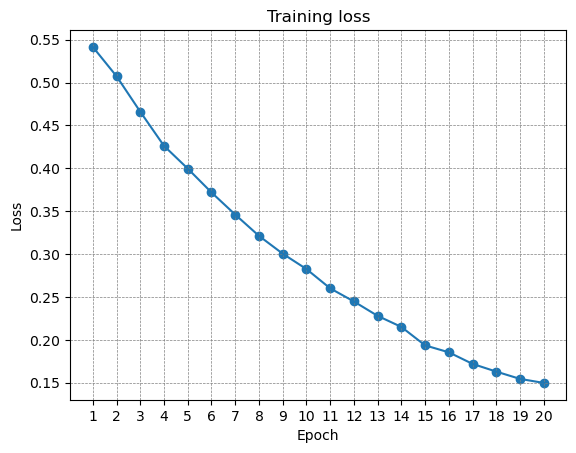

In [11]:
# A simple plot to visualize training loss
import matplotlib.pyplot as plt

plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.plot(history['epochs'],history['loss'])
plt.scatter(history['epochs'],history['loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.xticks(history['epochs'])

plt.ylabel('Loss')
plt.show()

## Notes:

From the above plot, we see that the training loss decreases in later epochs. This gives an indication of that the model is learning from the training process.

The evaluation of this fine-tuned model will be done in a following notebook. This notebook serves as reference code pipeline for fine tuning Gemma 2 using keras nlp library. We covered some of the key architectural details of Gemma 2 model, and  high-level topics related to training and fine-tuning LLMs. 

##### Additional util functions

In [23]:
## Util function to clean GPU 
import gc
import ctypes
import torch
import tensorflow as tf
tf.keras.backend.clear_session()
def clean_memory(deep=False):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [24]:
# del(gemma_lm)

clean_memory()